### Gaussian Processes with Random Fourier Features

http://random-walks.org/content/misc/rff/rff.html

In [1]:
# !pip install gpytorch

import math
import torch
import gpytorch

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

We are doing this experiment for the RBF kernel.

In [2]:
def sample_rff(x, lengthscale, variance, num_functions, num_features):
    omega_shape = (num_functions, num_features, x.shape[-1])
    omega = torch.randn(omega_shape)
    omega = omega / lengthscale
    
    weights = torch.randn((num_functions, num_features))
    
    phi = torch.rand((num_functions, num_features, 1)) * (2 * math.pi)

    features = torch.cos(torch.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / num_features) ** 0.5 * features * (variance ** 0.5)
    
    functions = torch.einsum('sf, sfn -> sn', weights, features)
    
    return functions, features

### Drawing samples from prior

In [3]:
lengthscale = 1.
variance = 4.
num_functions = 5
num_features = 200

x = torch.linspace(-3., 3., 50).reshape(-1,1)

functions, features = sample_rff(x, lengthscale, variance, num_functions, num_features)

display(functions.shape, features.shape)

torch.Size([5, 50])

torch.Size([5, 200, 50])

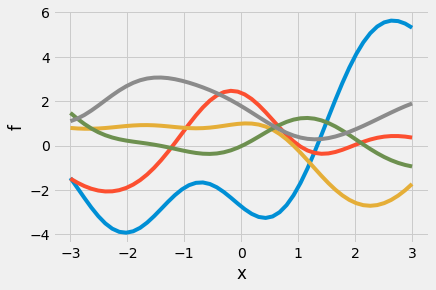

In [4]:
plt.plot(x, functions.T);
plt.xlabel('x');
plt.ylabel('f');

### RFF Posterior

In [5]:
def rff_posterior(x_train, y_train, x_test, lengthscale, variance, num_features, noise_var):
    
    x_full = torch.cat([x_test, x_train])
    
    _, features = sample_rff(x_full, lengthscale, variance, num_functions=1, num_features=num_features)
    features = features[0]
    
    features_test = features[:, :-x_train.shape[0]]
    features_train = features[:, -x_train.shape[0]:]
    
    iS = torch.eye(features_train.shape[0]) + (features_train @ features_train.T)/noise_var

    mean_pred = (features_test.T @ torch.linalg.solve(iS, features_train @ y_train))/noise_var
    
    var_pred = torch.einsum('fn, fn -> n',
                         features_test,
                         torch.linalg.solve(iS, features_test))
    
    return mean_pred, var_pred

### Regression on a real data

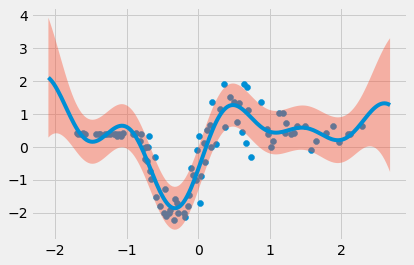

In [6]:
from regdata import Jump1D, DellaGattaGene, MotorcycleHelmet, Olympic

data = MotorcycleHelmet

x_train, y_train, x_test = map(lambda x:x.float(), data(backend='torch').get_data())


lengthscale = 0.5
variance = 4.
num_functions = 5
num_features = 400
noise_var = 0.1

rff_pred, rff_var = rff_posterior(x_train, y_train, x_test, lengthscale, variance, num_features, noise_var)

std2 = ((rff_var + noise_var) ** 0.5) * 2
plt.scatter(x_train, y_train, label='data');
plt.plot(x_test, rff_pred);
plt.fill_between(x_test.ravel(), rff_pred-std2, rff_pred+std2, alpha=0.4);

### TODO: Optimize the hyperparameters with torch